## Image Generation with GANs

#### Prasanth Dwadasi

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime

## Deep Convolutional GAN (DCGAN)





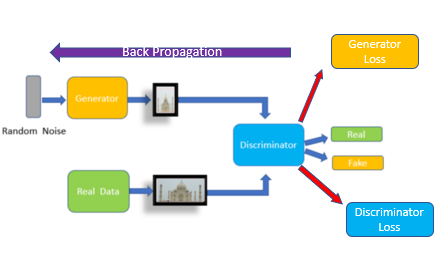

### Why were GANs developed in the first place?

It has been noticed most of the mainstream neural nets can be easily fooled into misclassifying things by adding only a small amount of noise into the original data. Surprisingly, the model after adding noise has higher confidence in the wrong prediction than when it predicted correctly. The reason for such an adversary is that most machine learning models learn from a limited amount of data, which is a huge drawback, as it is prone to overfitting. Also, the mapping between the input and the output is almost linear. Although it may seem that the boundaries of separation between the various classes are linear, in reality, they are composed of linearities and even a small change in a point in the feature space might lead to misclassification of data.

### How does GANs work?

**GANs** learn a probability distribution of a dataset by pitting two neural networks against each other.


One neural network, called the **Generator**, generates new data instances, while the other, the **Discriminator**, evaluates them for authenticity; i.e. the discriminator decides whether each instance of data that it reviews belongs to the actual training dataset or not.


Meanwhile, the generator is creating new, synthetic/fake images that it passes to the discriminator. It does so in the hopes that they, too, will be deemed authentic, even though they are fake. The fake image is generated from a 100-dimensional noise (uniform distribution between -1.0 to 1.0) using the inverse of convolution, called transposed convolution.


The goal of the generator is to generate passable images: to lie without being caught. The goal of the discriminator is to identify images coming from the generator as fake.


Here are the steps a GAN takes:

1. The generator takes in random numbers and returns an image.

2. This generated image is fed into the discriminator alongside a stream of images taken from the actual, ground-truth dataset.

3. The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake.

So you have a double feedback loop:

1. The discriminator is in a feedback loop with the ground truth of the images, which we know.

2. The generator is in a feedback loop with the discriminator.

In [3]:
 tf.keras.backend.clear_session()  # For easy reset of notebook state.

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [5]:
## Load the TMNIST data
data = pd.read_csv('./94_character_TMNIST.csv')
data.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
##remove the first 2 columns and take only pixel values
data = data.iloc[:, 2:786]
data.shape

(274093, 784)

In [7]:
# Standarize image data
train_images = data.values.reshape(data.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# [-1, 1] normalization
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

(274093, 28, 28, 1)


In [8]:
# Convert train_images into a tf.data.Dataset 
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
# Refer: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
'''
Creates a Dataset whose elements are slices of the given tensors. 
The given tensors are sliced along their first dimension.
'''

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


### Define a GAN Model

Next, a GAN model can be defined that combines both the generator model and the discriminator model into one larger model. This larger model will be used to train the model weights in the generator, using the output and error calculated by the discriminator model. The discriminator model is trained separately, and as such, the model weights are marked as not trainable in this larger GAN model to ensure that only the weights of the generator model are updated. This change to the trainability of the discriminator weights only affects when training the combined GAN model, not when training the discriminator standalone.

This larger GAN model takes as input a point in the latent space, uses the generator model to generate an image, which is fed as input to the discriminator model, then output or classified as real or fake.

Since the output of the Discriminator is sigmoid, we use binary cross-entropy for the loss. RMSProp as an optimizer generates more realistic fake images compared to Adam for this case. The learning rate is 0.0001. Weight decay and clip value stabilize learning during the latter part of the training. You have to adjust the decay if you want to adjust the learning rate.

GANs try to replicate a probability distribution. Therefore, we should use loss functions that reflect the distance between the distribution of the data generated by the GAN and the distribution of the real data.

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    
    # assert is used to debug
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

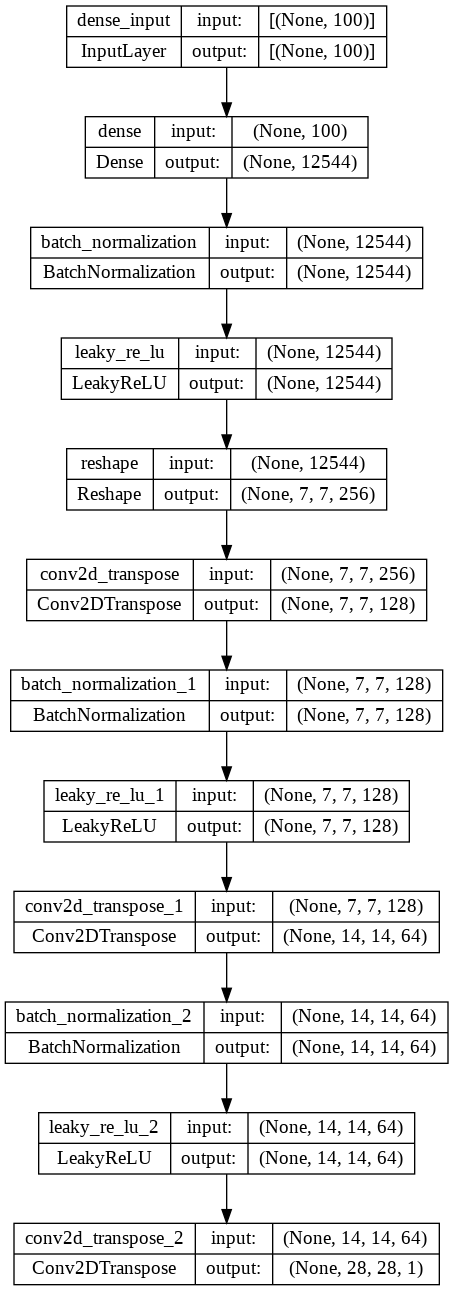

In [10]:
generator = make_generator_model()

keras.utils.plot_model(generator, 'generator.png', show_shapes=True)

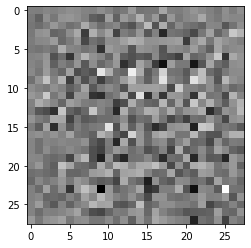

In [11]:
noise = tf.random.normal([1, 100])

# forward-pass through the generator 
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

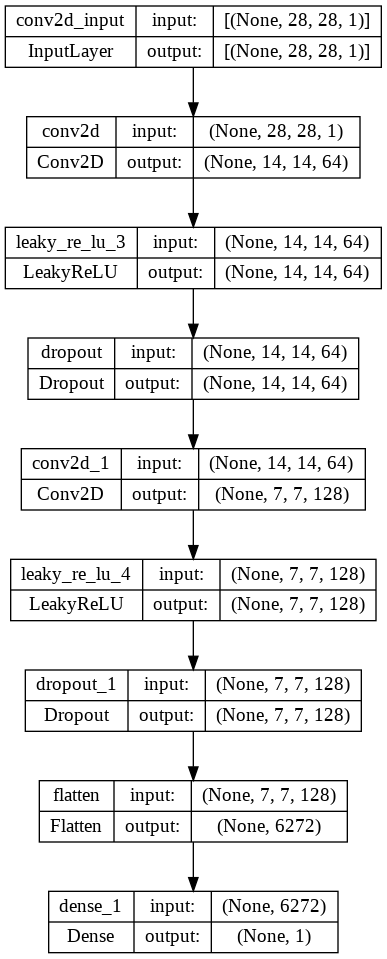

In [13]:
discriminator = make_discriminator_model()
keras.utils.plot_model(discriminator, 'discriminator.png', show_shapes=True)

In [14]:
decision = discriminator(generated_image) # forward-pass. model not yet trained
print (decision)

tf.Tensor([[-0.00270493]], shape=(1, 1), dtype=float32)


In [15]:
# Loss: Binary CrossEntropy <=> log-loss

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
# For the discrimanator,  0 => fake and 1 => real image
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # tf.ones creates a tensor of ones
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #tf.zeros creates a tensor of zeros
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator) # what objects to store in a ckpt

In [20]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

# We will reuse these test_random_vectors overtime (so it's easier)
# to visualize progress in the animated GIF)
test_random_vectors = tf.random.normal([num_examples_to_generate, noise_dim])
print(test_random_vectors.shape)

(16, 100)


### Training the GAN model:


Training is the hardest part and since a GAN contains two separately trained networks, its training algorithm must address two complications:

GANs must juggle two different kinds of training (generator and discriminator).

GAN convergence is hard to identify.

As the generator improves with training, the discriminator performance gets worse because the discriminator can’t easily tell the difference between real and fake. If the generator succeeds perfectly, then the discriminator has a 50% accuracy. In effect, the discriminator flips a coin to make its prediction.


This progression poses a problem for convergence of the GAN as a whole: the discriminator feedback gets less meaningful over time. If the GAN continues training past the point when the discriminator is giving completely random feedback, then the generator starts to train on junk feedback, and its quality may collapse.

In [21]:
# This annotation(decorator) causes the function to be "compiled" into a TF Graph
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [23]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1, test_random_vectors)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           test_random_vectors)

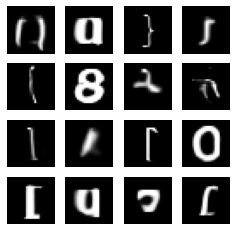

In [36]:
train(train_dataset, EPOCHS)

Now if we generate an image from noise we can observe a shape

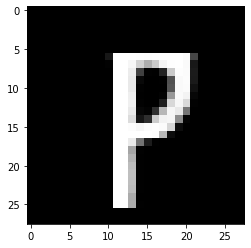

In [47]:
noise = tf.random.normal([1, 100])

# forward-pass through the generator 
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Now lets generate 40 fake images

In [52]:
generated_images = []

for i in range(40):
  noise = tf.random.normal([1, 100])
  generated_images.append(np.asarray(generator(noise, training=False)))



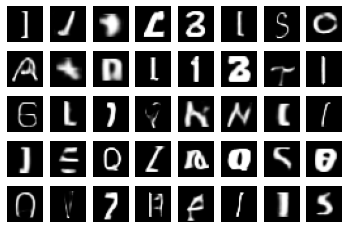

In [54]:
import os
import matplotlib.pyplot as plt
import PIL
%matplotlib inline
rows=5
for num, generated_image in enumerate(generated_images):
    # img = PIL.Image.open(generated_image[0, :, :, 0])
    plt.subplot(rows,8,num+1)
    plt.axis('off')
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    # plt.imshow(img, cmap='gray')

### Takeaways

Even though we have more than 200k images still the results arent satisfactory.

As GAN is sensitive to hyper parameters and 300 epochs weren't enough to train the generator

If we have trained aroung 1k epochs with some tuning in Hyperparameters might have yielded good results.

GANS are know to yeild slow results and sometimes it is possible that the generator loss becomes loss 0 but  discriminator loss will keep increasing.

&nbsp;

&nbsp;

References:
https://www.tensorflow.org/tutorials/generative/dcgan


MIT License

Copyright (c) 2022 Prasanth Dwadasi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.